# Introduction to image segmentation

In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import numpy as np
from skimage import draw

# Dataset Generation
The code implements a synthetic dataset generator that creates circle images with noise.
1. **Input Generation**:
   - Creates random circles with varying positions and sizes
   - Adds Gaussian noise to create noisy input images
2. **Target Generation**:
   - Clean circle images without noise
   - Created using distance-based calculation

In [2]:
# Create a simple dataset
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a random input image
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 4)

        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target = (distance < radius).float().unsqueeze(0)

        # Add noise to the target to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.8
        input_image = target + noise

        return input_image, target

/usr/local/lib/python3.10/dist-packages/torch/functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3595.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


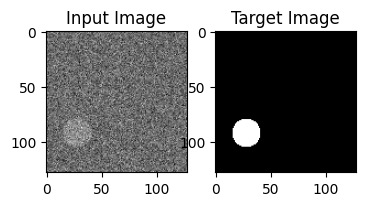

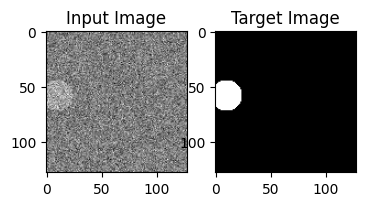

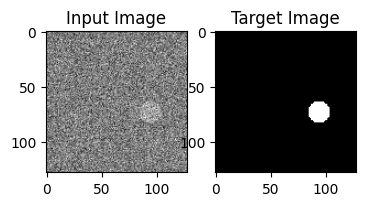

In [3]:
import matplotlib.pyplot as plt
# Create an instance of the dataset
dataset = SimpleDataset(size=1, image_size=128)

# Get a sample from the dataset
for i in range(3):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(4, 2))
    plt.subplot(1, 2, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    # plt.show()
    # Visualize the target image
    plt.subplot(1, 2, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Image')
    plt.show()
    # break


# Model Architectures: Simple image to image

[Simple Autoencoder](https://blog.paperspace.com/convolutional-autoencoder/)

Features:
- Single downsample layer (Conv2d)
- Single upsample layer (ConvTranspose2d)
- Minimal architecture for demonstration

In [4]:
# Define a simple model with ConvTranspose2d
class SimpleAutoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        # Conv layer to reduce spatial dimensions
        self.conv = nn.Conv2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)
        # ConvTranspose2d layer to increase spatial dimensions
        self.conv_transpose = nn.ConvTranspose2d(in_channels=1, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        # Downsample
        x = self.conv(x)
        # Upsample
        x = self.conv_transpose(x)
        x=torch.sigmoid(x)
        return x

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [6]:
# Training loop
def training_loop(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

In [7]:
# Initialize the model, loss function, and optimizer
model = SimpleAutoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.2364
Epoch [2/100], Average Loss: 0.2341
Epoch [3/100], Average Loss: 0.2318
Epoch [4/100], Average Loss: 0.2295
Epoch [5/100], Average Loss: 0.2272
Epoch [6/100], Average Loss: 0.2240
Epoch [7/100], Average Loss: 0.2221
Epoch [8/100], Average Loss: 0.2189
Epoch [9/100], Average Loss: 0.2167
Epoch [10/100], Average Loss: 0.2136
Epoch [11/100], Average Loss: 0.2101
Epoch [12/100], Average Loss: 0.2066
Epoch [13/100], Average Loss: 0.2024
Epoch [14/100], Average Loss: 0.1981
Epoch [15/100], Average Loss: 0.1940
Epoch [16/100], Average Loss: 0.1895
Epoch [17/100], Average Loss: 0.1848
Epoch [18/100], Average Loss: 0.1806
Epoch [19/100], Average Loss: 0.1761
Epoch [20/100], Average Loss: 0.1717
Epoch [21/100], Average Loss: 0.1673
Epoch [22/100], Average Loss: 0.1633
Epoch [23/100], Average Loss: 0.1589
Epoch [24/100], Average Loss: 0.1545
Epoch [25/100], Average Loss: 0.1508
Epoch [26/100], Average Loss: 0.1460
Epoch [27/100], Average Loss: 0.1417
Epoch [28/

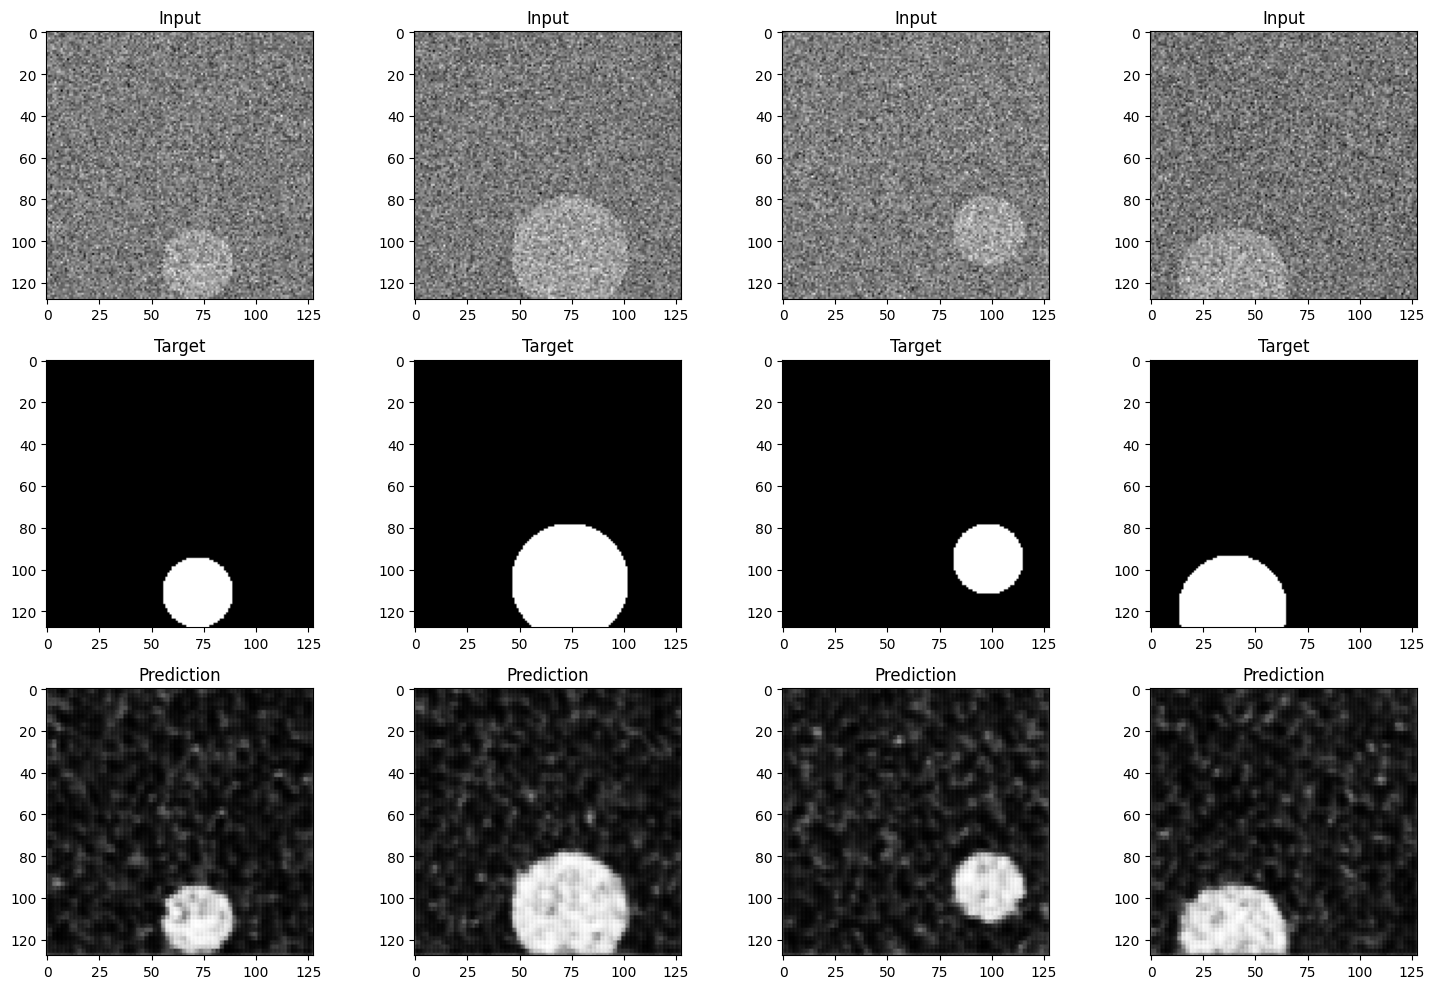

In [8]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

### Advanced Autoencoder
Architecture Details:
1. **Encoder**:
   - Progressive feature extraction
   - Increasing channel depth (1→16→32→64)
   - Decreasing spatial dimensions
   - ReLU activation for non-linearity

2. **Decoder**:
   - Mirror structure of encoder
   - Decreasing channel depth (64→32→16→1)
   - Increasing spatial dimensions
   - Sigmoid activation for final output

3. **Key Components**:
   - `output_padding=1`: Handles odd dimensions in upsampling
   - Symmetric channel progression
   - Skip connections not implemented (could be added for better results)


![picture](https://miro.medium.com/v2/resize:fit:640/format:webp/1*nqzWupxC60iAH2dYrFT78Q.png)

credit image: https://medium.com/@birla.deepak26/autoencoders-76bb49ae6a8f

In [9]:
# Define the autoencoder model
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 7)
        )
        # Decoder
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(64, 32, 7),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 16, 3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [10]:
model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.2230
Epoch [2/100], Average Loss: 0.0798
Epoch [3/100], Average Loss: 0.0791
Epoch [4/100], Average Loss: 0.0643
Epoch [5/100], Average Loss: 0.0729
Epoch [6/100], Average Loss: 0.0749
Epoch [7/100], Average Loss: 0.0701
Epoch [8/100], Average Loss: 0.0752
Epoch [9/100], Average Loss: 0.0741
Epoch [10/100], Average Loss: 0.0713
Epoch [11/100], Average Loss: 0.0704
Epoch [12/100], Average Loss: 0.0709
Epoch [13/100], Average Loss: 0.0707
Epoch [14/100], Average Loss: 0.0758
Epoch [15/100], Average Loss: 0.0686
Epoch [16/100], Average Loss: 0.0740
Epoch [17/100], Average Loss: 0.0769
Epoch [18/100], Average Loss: 0.0759
Epoch [19/100], Average Loss: 0.0702
Epoch [20/100], Average Loss: 0.0724
Epoch [21/100], Average Loss: 0.0703
Epoch [22/100], Average Loss: 0.0709
Epoch [23/100], Average Loss: 0.0523
Epoch [24/100], Average Loss: 0.0324
Epoch [25/100], Average Loss: 0.0241
Epoch [26/100], Average Loss: 0.0170
Epoch [27/100], Average Loss: 0.0171
Epoch [28/

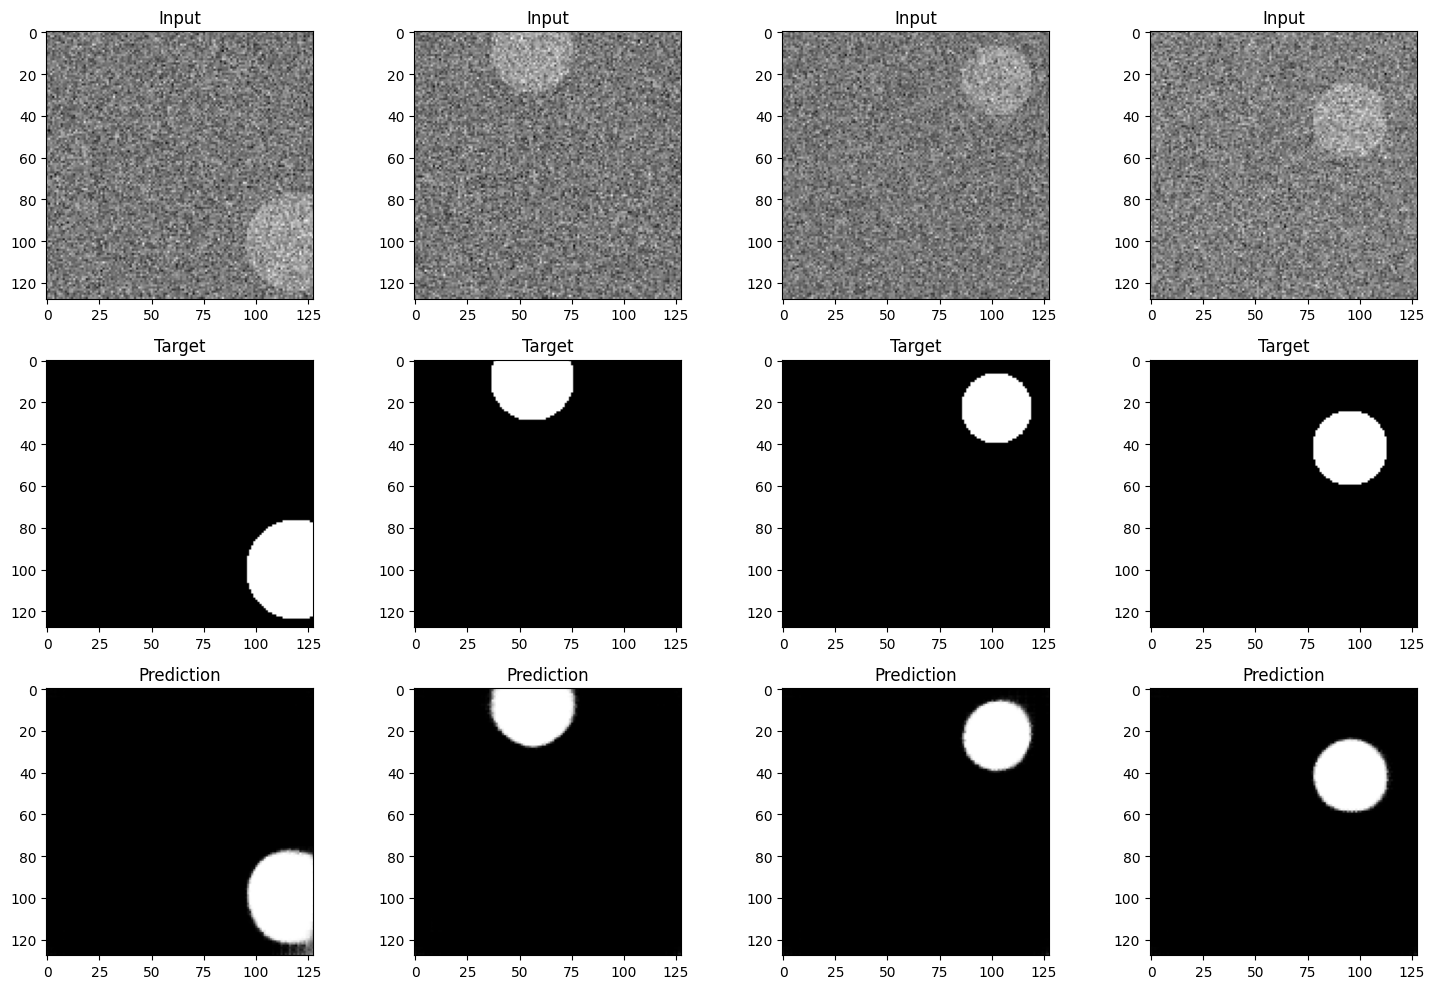

In [11]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(train_loader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

## Common Issues and Solutions

1. **Checkerboard Artifacts**:
   - Caused by transposed convolutions
   - Solution: Use resize-convolution instead

2. **Blurry Outputs**:
   - Common with MSE loss
   - Solution: Add perceptual or adversarial loss

3. **Training Stability**:
   - Monitor loss curves
   - Adjust learning rate if needed
   - Add gradient clipping if necessary

# U-Net architecture
[Pytorch-UNet](https://github.com/milesial/Pytorch-UNet)

U-Net is a convolutional neural network architecture designed for biomedical image segmentation. Its name comes from its U-shaped architecture, consisting of:
- Contracting path (encoder)
- Expanding path (decoder)
- Skip connections between corresponding encoder and decoder layers
### Data Flow:

1. **Encoder Path**:
   - Input → e1: 1→64 channels
   - e1 → e2: 64→128 channels
   - e2 → e3: 128→256 channels
   - e3 → e4: 256→512 channels

2. **Skip Connections**:
   - d1 + e3: 256 + 256 = 512 channels
   - d2 + e2: 128 + 128 = 256 channels
   - d3 + e1: 64 + 64 = 128 channels

3. **Decoder Path**:
   - e4 → d1: 512→256 channels
   - [d1,e3] → d2: 512→128 channels
   - [d2,e2] → d3: 256→64 channels
   - [d3,e1] → out: 128→1 channels

![picture](https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-07_at_9.08.00_PM_rpNArED.png)

credit image: https://arxiv.org/abs/1505.04597v1

In [12]:
# Define the U-Net architecture
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [13]:
model = UNet(in_channels=1, out_channels=1).to(device)
# criterion = nn.MSELoss()
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.7690
Epoch [2/100], Average Loss: 0.3825
Epoch [3/100], Average Loss: 0.2434
Epoch [4/100], Average Loss: 0.1837
Epoch [5/100], Average Loss: 0.1515
Epoch [6/100], Average Loss: 0.1221
Epoch [7/100], Average Loss: 0.0825
Epoch [8/100], Average Loss: 0.0803
Epoch [9/100], Average Loss: 0.0931
Epoch [10/100], Average Loss: 0.0753
Epoch [11/100], Average Loss: 0.0713
Epoch [12/100], Average Loss: 0.0711
Epoch [13/100], Average Loss: 0.0623
Epoch [14/100], Average Loss: 0.0110
Epoch [15/100], Average Loss: 0.0151
Epoch [16/100], Average Loss: 0.0103
Epoch [17/100], Average Loss: 0.0098
Epoch [18/100], Average Loss: 0.0080
Epoch [19/100], Average Loss: 0.0082
Epoch [20/100], Average Loss: 0.0075
Epoch [21/100], Average Loss: 0.0065
Epoch [22/100], Average Loss: 0.0067
Epoch [23/100], Average Loss: 0.0069
Epoch [24/100], Average Loss: 0.0064
Epoch [25/100], Average Loss: 0.0069
Epoch [26/100], Average Loss: 0.0066
Epoch [27/100], Average Loss: 0.0067
Epoch [28/

In [14]:
# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

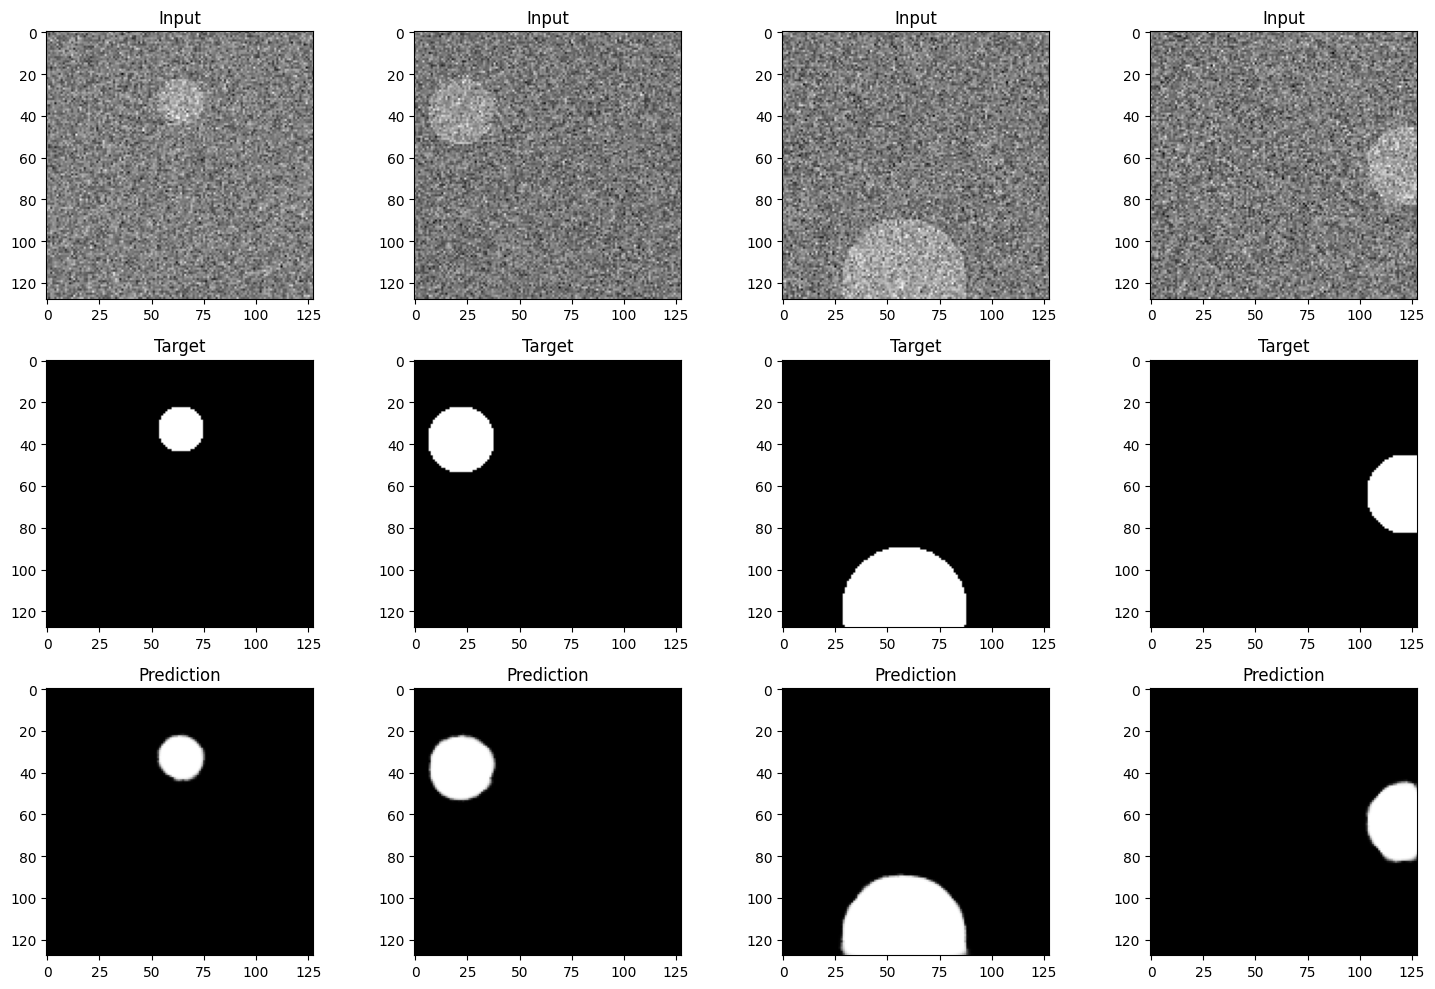

In [15]:
# Visualize results
model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(3, 4, figsize=(15, 10))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target')
        axes[2, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[2, i].set_title('Prediction')

    plt.tight_layout()
    plt.show()

In [ ]:
# !pip install torchviz

In [ ]:
# # Visualize the model architecture
# from torchviz import make_dot

# x = torch.randn(1, 1, 128, 128).to(device)
# y = model(x)
# dot = make_dot(y.mean(), params=dict(model.named_parameters()))
# dot.render("unet_architecture", format="png")

# Multiple object
- Channel 0: Circle mask
- Channel 1: Rectangle mask

In [16]:
class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128):
        self.size = size
        self.image_size = image_size

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        # Create a blank canvas for target
        target = torch.zeros(2, self.image_size, self.image_size)

        # Generate circle
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 6)
        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target[0] = (distance < radius).float()

        # Generate rectangle
        rect_x = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_y = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_w = np.random.randint(self.image_size // 8, self.image_size // 4)
        rect_h = np.random.randint(self.image_size // 8, self.image_size // 4)
        target[1, rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1

        # Combine circle and rectangle
        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        # Add noise to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.5
        input_image = combined_target + noise

        return input_image, target

# U-Net Architecture for Multiple Objects
## Implementation Details
1. **Input Processing**:
   - Single channel noisy image
   - Size: 128x128x1

2. **Feature Extraction**:
   - Progressive downsampling
   - Increasing feature channels

3. **Decoding Process**:
   - Progressive upsampling
   - Skip connections
   - Final output: 2 channel masks

4. **Output Processing**:
   - Channel 0: Circle probability map
   - Channel 1: Rectangle probability map

In [17]:
# Define the U-Net architecture (unchanged)
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [18]:
# Create the dataset and data loader
dataset = SimpleDataset()
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

In [21]:
model = UNet(in_channels=1, out_channels=2).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.7310
Epoch [2/100], Average Loss: 0.5328
Epoch [3/100], Average Loss: 0.4527
Epoch [4/100], Average Loss: 0.2292
Epoch [5/100], Average Loss: 0.1495
Epoch [6/100], Average Loss: 0.1129
Epoch [7/100], Average Loss: 0.0861
Epoch [8/100], Average Loss: 0.0666
Epoch [9/100], Average Loss: 0.0537
Epoch [10/100], Average Loss: 0.0531
Epoch [11/100], Average Loss: 0.0546
Epoch [12/100], Average Loss: 0.0480
Epoch [13/100], Average Loss: 0.0469
Epoch [14/100], Average Loss: 0.0465
Epoch [15/100], Average Loss: 0.0632
Epoch [16/100], Average Loss: 0.0536
Epoch [17/100], Average Loss: 0.0537
Epoch [18/100], Average Loss: 0.0526
Epoch [19/100], Average Loss: 0.0504
Epoch [20/100], Average Loss: 0.0535
Epoch [21/100], Average Loss: 0.0517
Epoch [22/100], Average Loss: 0.0504
Epoch [23/100], Average Loss: 0.0483
Epoch [24/100], Average Loss: 0.0454
Epoch [25/100], Average Loss: 0.0431
Epoch [26/100], Average Loss: 0.0414
Epoch [27/100], Average Loss: 0.0411
Epoch [28/

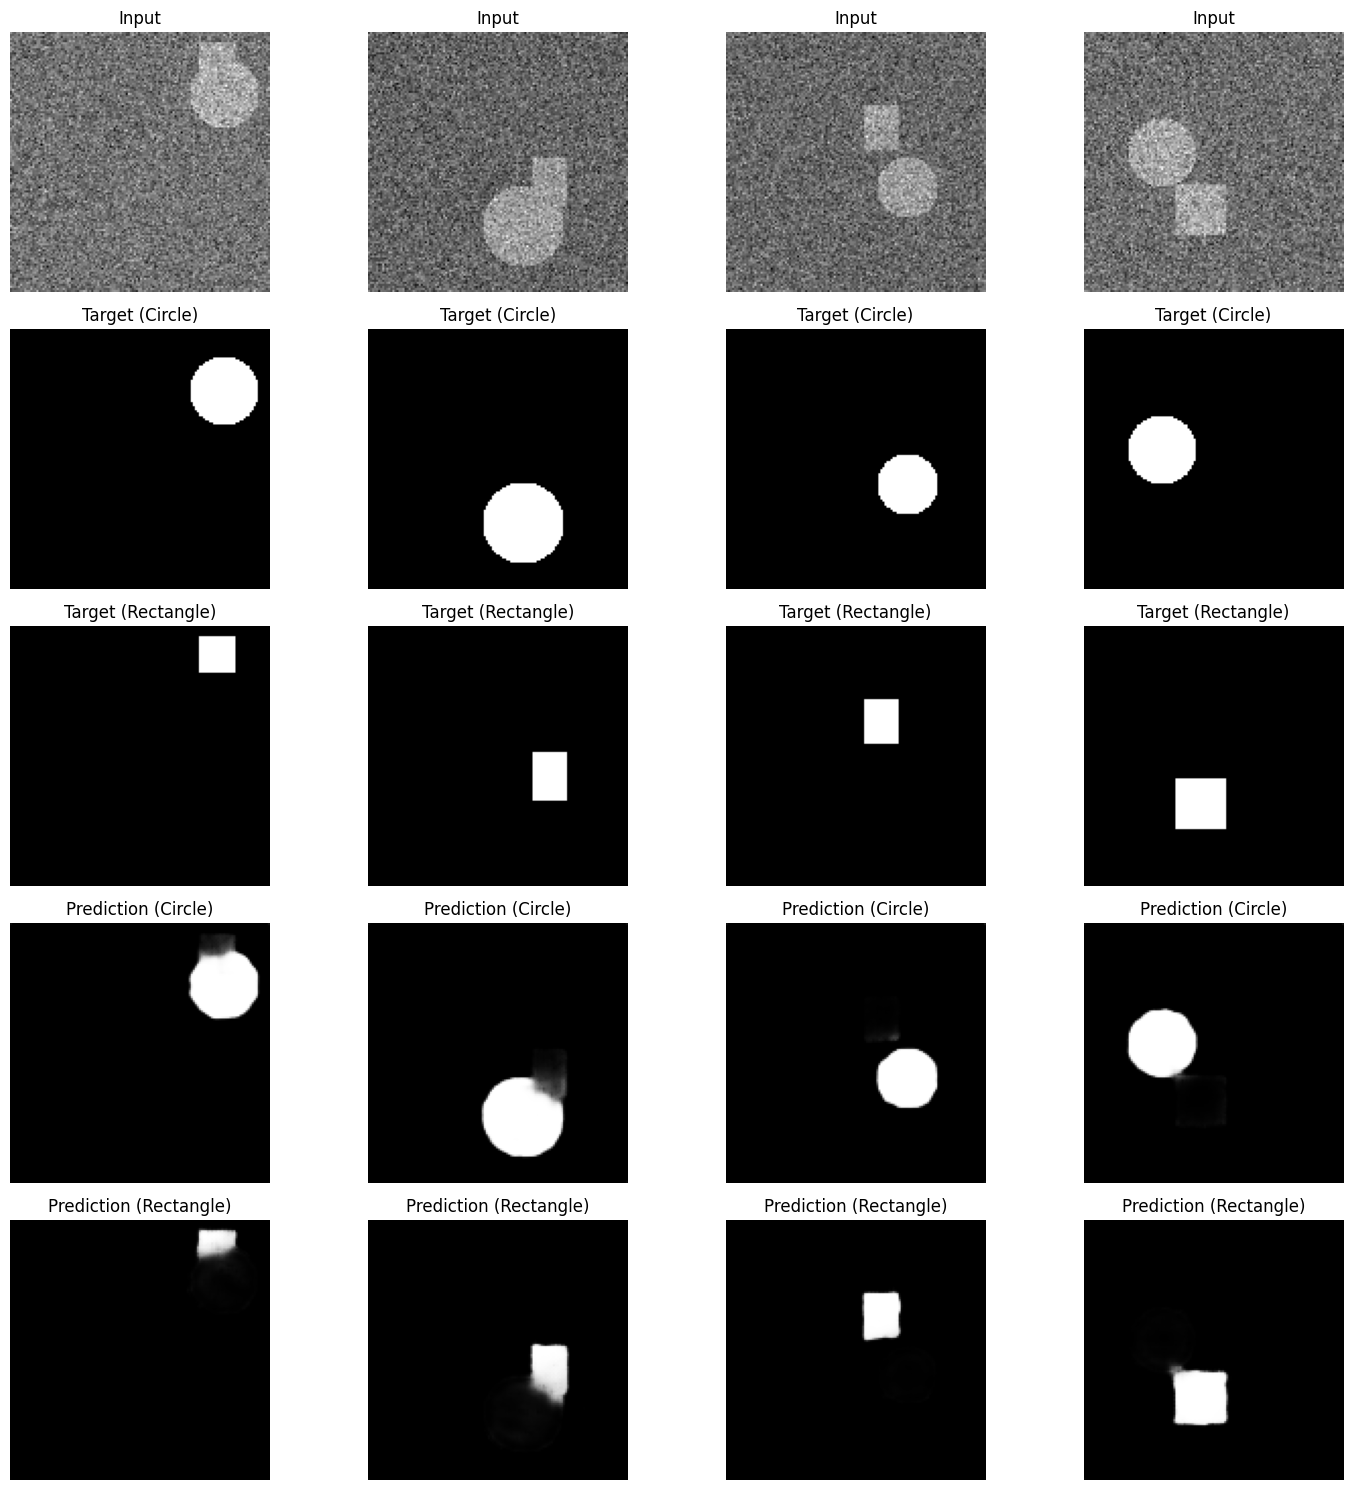

In [22]:
# Visualize results
# Create the dataset and data loader
dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(5, 4, figsize=(15, 15))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target (Circle)')
        axes[1, i].axis('off')

        axes[2, i].imshow(targets[i, 1].cpu(), cmap='gray')
        axes[2, i].set_title('Target (Rectangle)')
        axes[2, i].axis('off')

        axes[3, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[3, i].set_title('Prediction (Circle)')
        axes[3, i].axis('off')

        axes[4, i].imshow(outputs[i, 1].cpu(), cmap='gray')
        axes[4, i].set_title('Prediction (Rectangle)')
        axes[4, i].axis('off')

    plt.tight_layout()
    plt.show()

# Hand on

Revise the code to be able to segment 4 objects per image using U-Net.

In [23]:
from PIL import Image
import os

In [25]:
# Define the SimpleDataset with 4 objects

class SimpleDataset(Dataset):
    def __init__(self, size=100, image_size=128, save_path=None):
        self.size = size
        self.image_size = image_size
        self.save_path = save_path  # Path for saving input and target data

        # Create directories for saving data
        if save_path:
            os.makedirs(os.path.join(save_path, "input_images"), exist_ok=True)
            os.makedirs(os.path.join(save_path, "targets"), exist_ok=True)

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        target = torch.zeros(4, self.image_size, self.image_size)

        # Generate circle
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        radius = np.random.randint(10, self.image_size // 6)
        x, y = torch.meshgrid(torch.arange(self.image_size), torch.arange(self.image_size))
        distance = ((x - center_x)**2 + (y - center_y)**2).sqrt()
        target[0] = (distance < radius).float()

        # Generate rectangle
        rect_x = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_y = np.random.randint(0, self.image_size - self.image_size // 4)
        rect_w = np.random.randint(self.image_size // 8, self.image_size // 4)
        rect_h = np.random.randint(self.image_size // 8, self.image_size // 4)
        target[1, rect_x:rect_x+rect_w, rect_y:rect_y+rect_h] = 1

        # Generate triangle
        triangle = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        p1 = (np.random.randint(0, self.image_size), np.random.randint(0, self.image_size))
        p2 = (np.random.randint(0, self.image_size), np.random.randint(0, self.image_size))
        p3 = (np.random.randint(0, self.image_size), np.random.randint(0, self.image_size))
        rr, cc = draw.polygon([p1[0], p2[0], p3[0]], [p1[1], p2[1], p3[1]], triangle.shape)
        triangle[rr, cc] = 1
        target[2] = torch.from_numpy(triangle)

        # Generate ellipse
        ellipse = np.zeros((self.image_size, self.image_size), dtype=np.float32)
        center_x = np.random.randint(0, self.image_size)
        center_y = np.random.randint(0, self.image_size)
        axis_x = np.random.randint(10, self.image_size // 4)
        axis_y = np.random.randint(10, self.image_size // 4)
        rr, cc = draw.ellipse(center_x, center_y, axis_x, axis_y, shape=ellipse.shape)
        ellipse[rr, cc] = 1
        target[3] = torch.from_numpy(ellipse)

        # Combine all shapes
        combined_target = (target.sum(dim=0) > 0).float().unsqueeze(0)

        # Add noise to create the input image
        noise = torch.randn(1, self.image_size, self.image_size) * 0.5
        input_image = combined_target + noise

        # Save the data if save_path is provided
        if self.save_path:
            self.save_data(input_image, target, idx)

        return input_image, target

    # Opptional for saving image and target
    def save_data(self, input_image, target, idx):
        input_image_path = os.path.join(self.save_path, "input_images", f"input_{idx:04d}.png")
        target_path = os.path.join(self.save_path, "targets", f"target_{idx:04d}.npy")

        # Save input image as .png
        input_image_np = (input_image[0].cpu().numpy() * 255).astype(np.uint8)
        Image.fromarray(input_image_np).save(input_image_path)

        # Save target as .npy
        target_np = target.cpu().numpy()
        np.save(target_path, target_np)

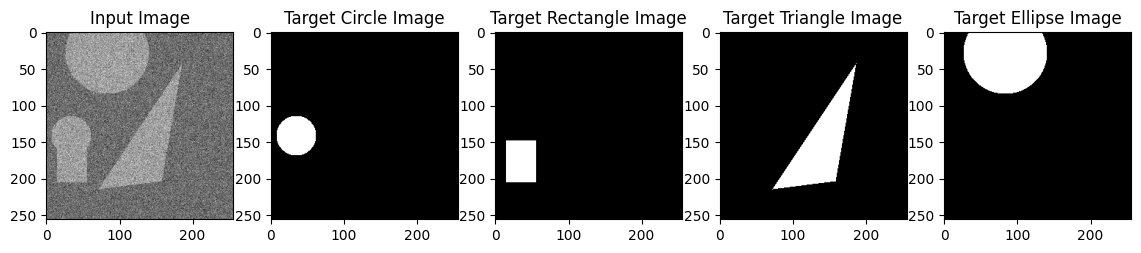

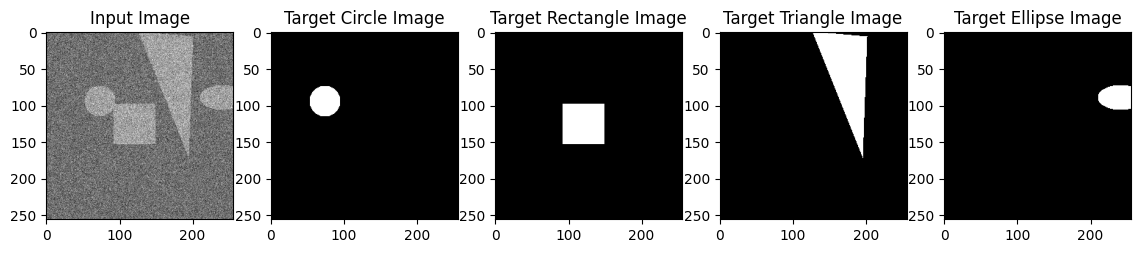

In [35]:
# Create an instance of the dataset
dataset = SimpleDataset(size=1, image_size=256)

# Get a sample from the dataset
for i in range(2):
    input_image, target = dataset[i]
    # Visualize the input image
    plt.figure(figsize=(14, 5))
    plt.subplot(1, 5, 1)
    plt.imshow(input_image[0], cmap='gray')
    plt.title('Input Image')
    # plt.show()

    # Visualize the target image
    plt.subplot(1, 5, 2)
    plt.imshow(target[0], cmap='gray')
    plt.title('Target Circle Image')

    # Visualize the target image
    plt.subplot(1, 5, 3)
    plt.imshow(target[1], cmap='gray')
    plt.title('Target Rectangle Image')

    # Visualize the target image
    plt.subplot(1, 5, 4)
    plt.imshow(target[2], cmap='gray')
    plt.title('Target Triangle Image')

    # Visualize the target image
    plt.subplot(1, 5, 5)
    plt.imshow(target[3], cmap='gray')
    plt.title('Target Ellipse Image')
    plt.show()
    # break

In [36]:
# Define the U-Net architecture, code here
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Encoder (downsampling)
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)
        self.enc4 = self.conv_block(256, 512)

        # Decoder (upsampling)
        self.dec1 = self.upconv_block(512, 256)
        self.dec2 = self.upconv_block(512, 128)
        self.dec3 = self.upconv_block(256, 64)
        self.final = nn.Conv2d(128, out_channels, kernel_size=1)

    def conv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def upconv_block(self, in_ch, out_ch):
        return nn.Sequential(
            nn.ConvTranspose2d(in_ch, out_ch, 2, stride=2),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(nn.functional.max_pool2d(e1, 2))
        e3 = self.enc3(nn.functional.max_pool2d(e2, 2))
        e4 = self.enc4(nn.functional.max_pool2d(e3, 2))

        # Decoder
        d1 = self.dec1(e4)
        d2 = self.dec2(torch.cat([d1, e3], dim=1))
        d3 = self.dec3(torch.cat([d2, e2], dim=1))
        out = self.final(torch.cat([d3, e1], dim=1))

        return out

In [37]:
# Training setup, code here
def training_loop(model, train_loader, criterion, optimizer, num_epochs=10):
    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_idx, (data, targets) in enumerate(train_loader):
            data = data.to(device)
            targets = targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

            if (batch_idx + 1) % 100 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {loss.item():.4f}')

        avg_loss = train_loss / len(train_loader)
        print(f'Epoch [{epoch+1}/{num_epochs}], Average Loss: {avg_loss:.4f}')

In [ ]:
# Training loop, code here
dataset = SimpleDataset(size=100, image_size=128)
train_loader = DataLoader(dataset, batch_size=16, shuffle=True)

model = UNet(in_channels=1, out_channels=4).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters())

In [45]:
# Training loop
num_epochs = 100
training_loop(model, train_loader, criterion, optimizer, num_epochs)

Epoch [1/100], Average Loss: 0.0293
Epoch [2/100], Average Loss: 0.0290
Epoch [3/100], Average Loss: 0.0289
Epoch [4/100], Average Loss: 0.0289
Epoch [5/100], Average Loss: 0.0268
Epoch [6/100], Average Loss: 0.0268
Epoch [7/100], Average Loss: 0.0266
Epoch [8/100], Average Loss: 0.0282
Epoch [9/100], Average Loss: 0.0267
Epoch [10/100], Average Loss: 0.0274
Epoch [11/100], Average Loss: 0.0317
Epoch [12/100], Average Loss: 0.0314
Epoch [13/100], Average Loss: 0.0340
Epoch [14/100], Average Loss: 0.0328
Epoch [15/100], Average Loss: 0.0330
Epoch [16/100], Average Loss: 0.0316
Epoch [17/100], Average Loss: 0.0332
Epoch [18/100], Average Loss: 0.0356
Epoch [19/100], Average Loss: 0.0285
Epoch [20/100], Average Loss: 0.0332
Epoch [21/100], Average Loss: 0.0306
Epoch [22/100], Average Loss: 0.0314
Epoch [23/100], Average Loss: 0.0301
Epoch [24/100], Average Loss: 0.0376
Epoch [25/100], Average Loss: 0.0305
Epoch [26/100], Average Loss: 0.0332
Epoch [27/100], Average Loss: 0.0341
Epoch [28/

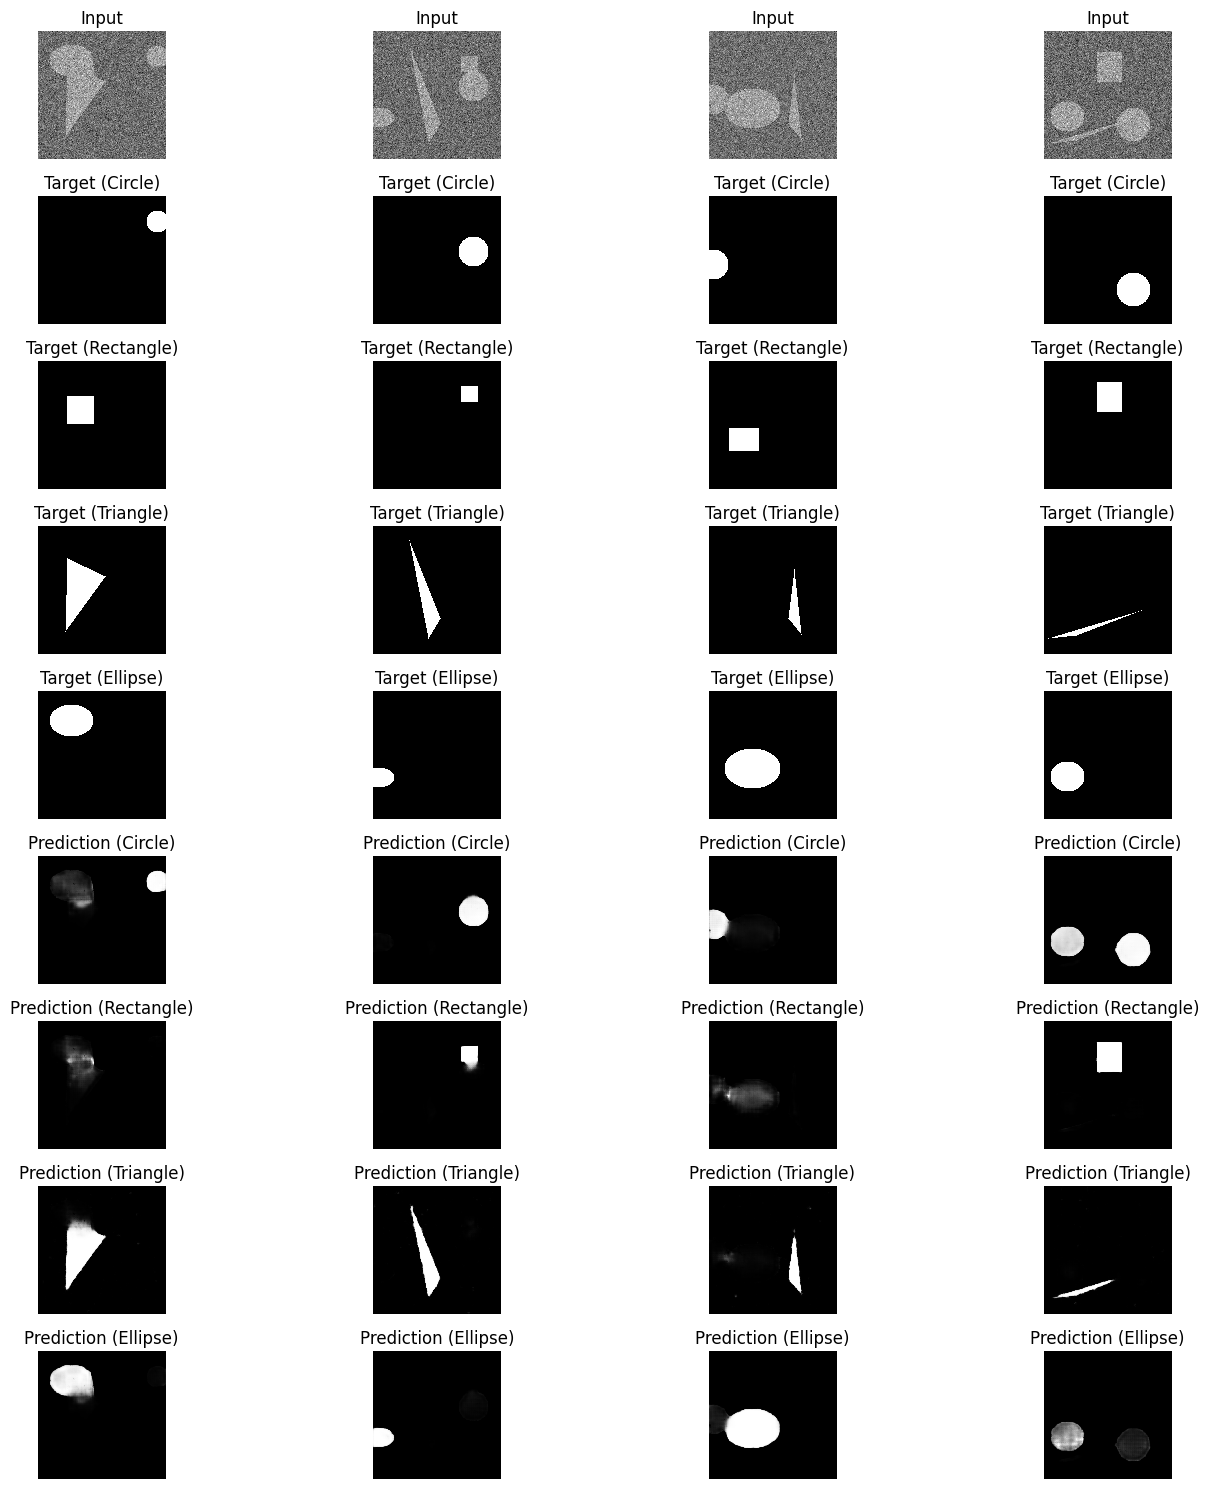

In [46]:
# Visualize results, code here

dataset = SimpleDataset()
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

model.eval()
with torch.no_grad():
    inputs, targets = next(iter(dataloader))
    inputs, targets = inputs.to(device), targets.to(device)
    outputs = model(inputs)
    outputs = torch.sigmoid(outputs)

    fig, axes = plt.subplots(9, 4, figsize=(15, 15))
    for i in range(4):
        axes[0, i].imshow(inputs[i, 0].cpu(), cmap='gray')
        axes[0, i].set_title('Input')
        axes[0, i].axis('off')

        axes[1, i].imshow(targets[i, 0].cpu(), cmap='gray')
        axes[1, i].set_title('Target (Circle)')
        axes[1, i].axis('off')

        axes[2, i].imshow(targets[i, 1].cpu(), cmap='gray')
        axes[2, i].set_title('Target (Rectangle)')
        axes[2, i].axis('off')

        axes[3, i].imshow(targets[i, 2].cpu(), cmap='gray')
        axes[3, i].set_title('Target (Triangle)')
        axes[3, i].axis('off')

        axes[4, i].imshow(targets[i, 3].cpu(), cmap='gray')
        axes[4, i].set_title('Target (Ellipse)')
        axes[4, i].axis('off')

        axes[5, i].imshow(outputs[i, 0].cpu(), cmap='gray')
        axes[5, i].set_title('Prediction (Circle)')
        axes[5, i].axis('off')

        axes[6, i].imshow(outputs[i, 1].cpu(), cmap='gray')
        axes[6, i].set_title('Prediction (Rectangle)')
        axes[6, i].axis('off')

        axes[7, i].imshow(outputs[i, 2].cpu(), cmap='gray')
        axes[7, i].set_title('Prediction (Triangle)')
        axes[7, i].axis('off')

        axes[8, i].imshow(outputs[i, 3].cpu(), cmap='gray')
        axes[8, i].set_title('Prediction (Ellipse)')
        axes[8, i].axis('off')

    plt.tight_layout()
    plt.show()

# High performance and well known model
https://pytorch.org/vision/stable/models.html

https://universe.roboflow.com/
